In [1]:
import ast
import os
import time
import numpy as np

import h5py 
import warnings
import glob
import sys

from lattice_translocators import LEFTranslocator
from lattice_translocators import LEFTranslocatorDynamicBoundary
import cooltools
import matplotlib.pylab as plt

# Making Arrays

### LEF arrays

In [3]:
def make_lef_arrays(paramdictx):
    
    N1 = paramdictx['monomer_per_replica']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    Lattice_sites = N1 * Sites_per_monomer
    M = paramdictx['replication_number']
    Separation = paramdictx['separation']
    LEFNum = (N1 * M) // Separation
    LIFETIME_WT = paramdictx['lifetime']
    velocity_multiplier = paramdictx['velocity_multiplier']
    LIFETIME = int(LIFETIME_WT * velocity_multiplier) * Sites_per_monomer 
           
    Array = np.zeros(Lattice_sites, dtype=np.double)
    birthArray = Array + 0.1 
    deathArray = Array + 1. / LIFETIME
    stallDeathArray = Array + 1 / LIFETIME
    pauseArray = Array
        
    return birthArray, deathArray, stallDeathArray, pauseArray, LEFNum

### STALL Arrays

In [4]:
def make_stall_array(paramdictx, RightstallList, LeftstallList):
    
    N1 = paramdictx['monomer_per_replica']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    Lattice_sites = N1 * Sites_per_monomer
    velocity_multiplier = paramdictx['velocity_multiplier']
    Facestall_wt = paramdictx['facestall']
    Backstall_wt = paramdictx['backstall']  
    Facestall =   1 - (1 - (Facestall_wt))**( 1/velocity_multiplier)
    Backstall =   1 - (1 - (Backstall_wt))**( 1/velocity_multiplier) 

    Array = np.zeros(Lattice_sites, dtype=np.double)
    stallRight = np.zeros(Lattice_sites, dtype=np.double)
    stallLeft = np.zeros(Lattice_sites, dtype=np.double)
    stallRight_c = np.zeros(Lattice_sites, dtype=np.double)
    stallLeft_c = np.zeros(Lattice_sites, dtype=np.double)
    
    for i in RightstallList:
        stallRight[i] = Facestall
        stallLeft[i] = Backstall

    for j in LeftstallList:
        stallRight_c[j] = Backstall
        stallLeft_c[j] = Facestall
        
    stallRightArray = stallRight + stallRight_c
    stallLeftArray = stallLeft + stallLeft_c
    
    return stallRightArray, stallLeftArray

### Translocation Arrays

In [5]:
def make_translocator(paramdictx, RightstallList, LeftstallList):
    
    N1 = paramdictx['monomer_per_replica']
    M = paramdictx['replication_number']
    SEPARATION = paramdictx['separation']
    Stalltime_WT = paramdictx['stalltime']
    Stalloftime_WT = paramdictx['stalloftime']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    velocity_multiplier = paramdictx['velocity_multiplier']
    stalltime = Stalltime_WT * velocity_multiplier * Sites_per_monomer
    stalloftime = Stalloftime_WT * velocity_multiplier * Sites_per_monomer
    
    birthArray, deathArray, stallDeathArray, pauseArray, LEFNum = make_lef_arrays(paramdictx)
    stallRightArray, stallLeftArray = make_stall_array(paramdictx, RightstallList, LeftstallList) 
    LEFTran = LEFTranslocatorDynamicBoundary(
        np.tile(birthArray,M), 
        np.tile(deathArray,M),
        np.tile(stallLeftArray,M),
        np.tile(stallRightArray,M),
        np.tile(pauseArray,M),
        np.tile(stallDeathArray,M),
        stalltime, 
        stalloftime,
        LEFNum)
    return LEFTran, LEFNum

### parameters

In [6]:
paramdict = {
    'lifetime':50,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':10,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':100,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
for i in range(len(paramdict)):
        exec("%s_WT=%d"%(str(list(paramdict)[i]).upper(),paramdict[list(paramdict)[i]]))

steps = int(STEPS_WT / VELOCITY_MULTIPLIER_WT)  

### testing arrays

In [7]:
paramdict1 = {
    'lifetime':10,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':1000,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':10,
    'replication_number':10
}

Lattice_sites1 = paramdict1['monomer_per_replica'] * paramdict1['sites_per_monomer']
RightstallList1 = [i for i in range(0, Lattice_sites1, 50)]
LeftstallList1 = [k for k in range(10, Lattice_sites1, 50)]
Stalldist = STALLDIST_WT * SITES_PER_MONOMER_WT 
l, lefnum = make_translocator(paramdict1, RightstallList1, LeftstallList1)
num_lefs1 = len(l.getLEFs()[1])
print(len(l.getLEFs()[1]))

paramdict5 = {
    'lifetime':30,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':1000,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':10,
    'replication_number':10
}

Lattice_sites5 = paramdict5['monomer_per_replica'] * paramdict5['sites_per_monomer']
RightstallList5 = [i for i in range(0, Lattice_sites5, 50)]
LeftstallList5 = [k for k in range(10, Lattice_sites5, 50)]
l, lefnum = make_translocator(paramdict5, RightstallList5, LeftstallList5)
num_lefs5 = len(l.getLEFs()[1])
print(len(l.getLEFs()[1]))

### testing lef number
assert num_lefs1 == num_lefs5


### testing processivity
dists1=[]
dists5=[]
TRAJ_LEN = 100
for j in range(10):
    l, lefnum = make_translocator(paramdict1, RightstallList1, LeftstallList1)
    l.steps(TRAJ_LEN)
    lefs1 = l.getLEFs()
    avg_dist_1 = np.mean(lefs1[1]-lefs1[0])
    dists1.append(avg_dist_1)
    

    l, lefnum = make_translocator(paramdict5, RightstallList5, LeftstallList5)
    l.steps(TRAJ_LEN * paramdict['sites_per_monomer'])
    lefs5 = l.getLEFs()
    avg_dist_5 = np.mean( lefs5[1]-lefs5[0])
    dists5.append(avg_dist_5)
print(np.mean(dists1), np.mean(dists5))

10
10
32.059999999999995 41.43


### making file name

In [8]:
def paramdict_to_filename(paramdictx):
    
    filename='file'
    for i in range(len(paramdictx)):
        filename += ('_'+list(paramdictx)[i][:3]+'_'+str(paramdictx[list(paramdictx)[i]]))
        
    return filename

### Validation, 1d simulation

In [10]:
########## parameters #############
paramdict = {
    'lifetime':50,
    'separation':10,
    'facestall':1,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':100,
    'replication_number':10
}

N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
Sites_per_monomer = paramdict['sites_per_monomer']
Lattice_sites = N1 * Sites_per_monomer

RightstallList = [i for i in range(3 * Sites_per_monomer, Lattice_sites, Lattice_sites // 4)]
LeftstallList = [k for k in range(3 * Sites_per_monomer, Lattice_sites, Lattice_sites // 4)]
LEFTran, LEFNum = make_translocator(paramdict, RightstallList, LeftstallList)



############# making folder for simulation ###############
file_name = paramdict_to_filename(paramdict)
folder_name = '/samples/'+'folder_' + file_name.split('file_')[1]
folder = os.getcwd() + folder_name

if os.path.exists(folder):
    print("already exist")
else:
    os.mkdir(folder)


########### simulation parameters ###########
Trajn = 100 # trajectory length in monomer 
trajectoryLength = Trajn * Sites_per_monomer #trajectory length in lattice land
num_dummy_steps = Trajn//100 * Sites_per_monomer #dummy steps in lattice land
blocksteps = 5 
bins = np.linspace(0, trajectoryLength, blocksteps, dtype=int)
 
    
#########   Making LEFs arrays during trajectory length #######      
with h5py.File(folder+"/LEFPositions.h5", mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), #edited
                                 dtype=np.int32, 
                                 compression="gzip")
    
    LEFTran.steps(num_dummy_steps)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            LEFTran.steps(1)
            LEFs = LEFTran.getLEFs()
            cur.append(np.array(LEFs).T)
        cur = np.array(cur)
        dset[st:end] = cur
    myfile.attrs["N"] = N #* Sites_per_monomer
    myfile.attrs["LEFNum"] = LEFNum


### 1 d Analysis

In [11]:
def map_from_lefs(dset, trajectoryLength, LEFNum, Lattice_sites):
    
    ll = np.mod(dset.reshape( (trajectoryLength * LEFNum, 2)), Lattice_sites)
    ll = ll[ll[:,1] > ll[:,0]]    
    lmap = np.histogram2d(ll[:,0],ll[:,1], np.arange(Lattice_sites))[0]
    
    return (lmap + lmap.T)

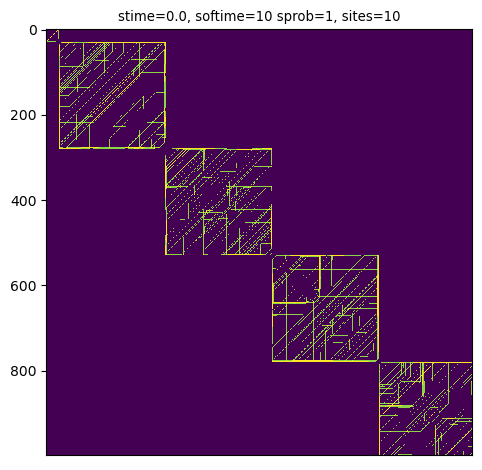

In [12]:
file_name = paramdict_to_filename(paramdict)
folder_name = '/samples/'+'folder_' + file_name.split('file_')[1]
folder = os.getcwd() + folder_name

if os.path.exists(folder):
    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
            lef_array = np.array(myfile['positions'])
            Trajn = 100 # trajectory length in monomer 
            trajectoryLength = Trajn * paramdict['sites_per_monomer'] #trajectory length in lattice land
            Lattice_sites = paramdict['monomer_per_replica']*paramdict['sites_per_monomer']
            N = myfile.attrs["N"] #number of monomers  
            LEFNum = myfile.attrs["LEFNum"]   #number of extruders
            maps = map_from_lefs(lef_array, trajectoryLength, LEFNum, Lattice_sites)
                    
            plt.matshow(np.log10(maps+1),vmax=1.15/(np.sqrt(paramdict['sites_per_monomer'])), fignum = False) 

                    
            plt.title('stime=%s, softime=%s sprob=%s, sites=%s'%(paramdict['stalltime'],
                                                                      paramdict['stalloftime'],
                                                                      paramdict['facestall'],
                                                                      paramdict['sites_per_monomer']),fontsize=9.51)
            plt.xticks([])
            plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()                       
                
